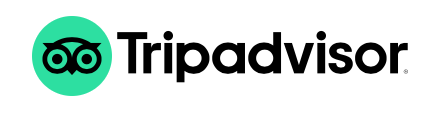
# Predict TripAdvisor Rating
## В этом соревновании нам предстоит предсказать рейтинг ресторана в TripAdvisor
### Данные:

Первоначальная версия датасета состоит из десяти столбцов, содержащих следующую информацию:

- Restaurant_id — идентификационный номер ресторана / сети ресторанов;
- City — город, в котором находится ресторан;
- Cuisine Style — кухня или кухни, к которым можно отнести блюда, предлагаемые в ресторане;
- Ranking — место, которое занимает данный ресторан среди всех ресторанов своего города;
- Rating — рейтинг ресторана по данным TripAdvisor (именно это значение должна будет предсказывать модель);
- Price Range — диапазон цен в ресторане;
- Number of Reviews — количество отзывов о ресторане;
- Reviews — данные о двух отзывах, которые отображаются на сайте ресторана;
- URL_TA — URL страницы ресторана на TripAdvosor;
- ID_TA — идентификатор ресторана в базе данных TripAdvisor.

# Изучаем предметную область.

[Everything You Need to Know About the Tripadvisor Popularity Ranking](https://www.tripadvisor.com/TripAdvisorInsights/w765)

Для определения ранка ресторана используется три критерия:
- качество отзыв (хороший отзыв улучшает ранк)
- актуальность отзыва (сведий отыа имеет больший вес, чем старый)
- количество отзывов укрепляет доверие

# Импортируем необходимые библиотеки

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

from itertools import combinations
from scipy.stats import ttest_ind
import statsmodels.api as sm
import scipy.stats as sst
from collections import Counter
import re

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

filenames_list = []
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        filenames_list.append(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.
import datetime

/kaggle/input/ptripadvisor/pTA.csv
/kaggle/input/sf-dst-restaurant-rating/sample_submission.csv
/kaggle/input/sf-dst-restaurant-rating/main_task.csv
/kaggle/input/sf-dst-restaurant-rating/kaggle_task.csv
/kaggle/input/module3/world.xlsx
/kaggle/input/module3/popC.xlsx


In [2]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [3]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

# Methods

In [4]:
def round_of_rating(number):
    return np.round(number * 2) / 2
def new_ranking(row):
    return np.round(5 - 4*(1-row['Ranking'])/(1-max_ranking[row['City']]),1)*2/2

# DATA

In [5]:
DATA_DIR = '/kaggle/input/sf-dst-restaurant-rating/'
df_train = pd.read_csv(DATA_DIR+'/main_task.csv')
df_test = pd.read_csv(DATA_DIR+'kaggle_task.csv')
sample_submission = pd.read_csv(DATA_DIR+'/sample_submission.csv')
wd = pd.read_excel('/kaggle/input/module3/world.xlsx')
df2 = pd.read_csv('/kaggle/input/ptripadvisor/pTA.csv')

# Проверяем файлы

In [6]:
sample_submission.sample(3)

Restaurant_id  Rating
9234       id_9234     3.0
9376       id_9376     5.0
5719       id_5719     2.5

In [7]:
df_train.sample(3)

Restaurant_id       City  \
32483       id_1871   Brussels   
12343       id_1598  Barcelona   
30376       id_3582       Rome   

                                          Cuisine Style  Ranking  Rating  \
32483                                               NaN   1872.0     4.5   
12343  ['Cafe', 'Vegetarian Friendly', 'Vegan Options']   1599.0     4.5   
30376                                       ['Italian']   3583.0     4.0   

      Price Range  Number of Reviews  \
32483         NaN                4.0   
12343    $$ - $$$               53.0   
30376    $$ - $$$               69.0   

                                                 Reviews  \
32483  [['As spicy as in thailand', 'Reasonably good....   
12343  [['Simply lovely', 'Awesome food, great atmosp...   
30376  [['Gets better and better', 'Great Meal'], ['0...   

                                                  URL_TA      ID_TA  
32483  /Restaurant_Review-g188644-d11700928-Reviews-P...  d11700928  
12343  /Restaurant_Review-g187497-d11915261-Reviews-C...  d11915261  
30376  /Restaurant_Review-g187791-d3924021-Reviews-La...   d3924021

In [8]:
wd.sample(3)

Rank         City Country  Place  Product  Programming  People  \
85    86       Kuwait  Kuwait     92      197          253      26   
96    97  Mexico City  Mexico     73       77           62     141   
73    74         Lyon  France    136       64           89      98   

    Prosperity  Promotion  
85         117         45  
96         228         41  
73          42         94

In [9]:
df2.sample(3)

URL_TA  \
17326  /Restaurant_Review-g186525-d2421832-Reviews-Vi...   
13841  /Restaurant_Review-g187497-d5795038-Reviews-El...   
11460  /Restaurant_Review-g187265-d2657883-Reviews-Ch...   

                                            Review_stars      date_1  \
17326  ['1', '1', '1', '3', '4', '4', '2', '3', '1', ...  2020-11-08   
13841  ['5', '4', '4', '2', '5', '4', '5', '5', '4', ...  2019-10-12   
11460  ['4', '4', '4', '1', '5', '4', '4', '5', '1', ...  2019-10-14   

           date_2      date_3      date_4      date_5      date_6      date_7  \
17326  2020-09-03  2020-08-24  2020-08-15  2020-08-14  2020-08-01  2020-07-26   
13841  2018-06-15  2017-10-26  2017-10-20  2017-05-05  2016-11-16  2016-06-28   
11460  2019-09-24  2019-06-14  2019-02-19  2018-09-26  2018-07-19  2017-10-25   

           date_8  ... Time_dif2 Time_dif3  Time_dif4  Time_dif5  Time_dif6  \
17326  2020-07-25  ...      10.0       9.0        1.0       13.0        6.0   
13841  2016-05-11  ...     232.0       6.0      168.0      170.0      141.0   
11460  2017-09-18  ...     102.0     115.0      146.0       69.0      267.0   

       Time_dif7  Time_dif8  Time_dif9  Time_dif10  Nr_of_Reviews  
17326        1.0       14.0       95.0       215.0            273  
13841       48.0        6.0       94.0      1349.0             49  
11460       37.0      216.0       15.0       987.0            319  

[3 rows x 23 columns]

In [10]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

df = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

In [11]:
df.sample(3)

Restaurant_id    City  \
15215         id_70   Paris   
36869       id_7809  London   
26776       id_9193  London   

                                           Cuisine Style  Ranking Price Range  \
15215  ['French', 'European', 'Vegetarian Friendly', ...     71.0        $$$$   
36869                                                NaN   7818.0         NaN   
26776                               ['Italian', 'Pizza']   9202.0    $$ - $$$   

       Number of Reviews                                            Reviews  \
15215              555.0  [['Beautiful space, excellent service, food n....   
36869                5.0  [['Lovely - great value - hearty meals', 'Icon...   
26776                2.0  [['Fabulous', 'Great Italian pizza with Italia...   

                                                  URL_TA      ID_TA  sample  \
15215  /Restaurant_Review-g187147-d695081-Reviews-Api...    d695081       1   
36869  /Restaurant_Review-g186338-d11876777-Reviews-W...  d11876777       1   
26776  /Restaurant_Review-g186338-d11992788-Reviews-N...  d11992788       1   

       Rating  
15215     4.5  
36869     5.0  
26776     5.0

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
Restaurant_id        50000 non-null object
City                 50000 non-null object
Cuisine Style        38410 non-null object
Ranking              50000 non-null float64
Price Range          32639 non-null object
Number of Reviews    46800 non-null float64
Reviews              49998 non-null object
URL_TA               50000 non-null object
ID_TA                50000 non-null object
sample               50000 non-null int64
Rating               50000 non-null float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


В наших данных есть немного пропущенных значений. Постораемся их заменить. Есть переменные, которые нудно представить в цифровом виде. 

# Cleaning and Prepping Data
Обычно данные содержат в себе кучу мусора, который необходимо почистить, для того чтобы привести их в приемлемый формат. Чистка данных — это необходимый этап решения почти любой реальной задачи.   
![](https://analyticsindiamag.com/wp-content/uploads/2018/01/data-cleaning.png)

## 1. Обработка NAN 
У наличия пропусков могут быть разные причины, но пропуски нужно либо заполнить, либо исключить из набора полностью. Но с пропусками нужно быть внимательным, **даже отсутствие информации может быть важным признаком!**   
По этому перед обработкой NAN лучше вынести информацию о наличии пропуска как отдельный признак 

### 2. Обработка признаков
Для начала посмотрим какие признаки у нас могут быть категориальными.

### 2.1 Restaurant_id

In [13]:
# Проверяем уникальность признака Restaurant_id. Есть повторения. 
df.Restaurant_id.value_counts()

id_436      19
id_227      19
id_871      19
id_633      19
id_344      18
            ..
id_9237      1
id_11419     1
id_13406     1
id_9530      1
id_13341     1
Name: Restaurant_id, Length: 13094, dtype: int64

Text(0.5, 1.0, 'Распределие пизнака Restaurant_id')

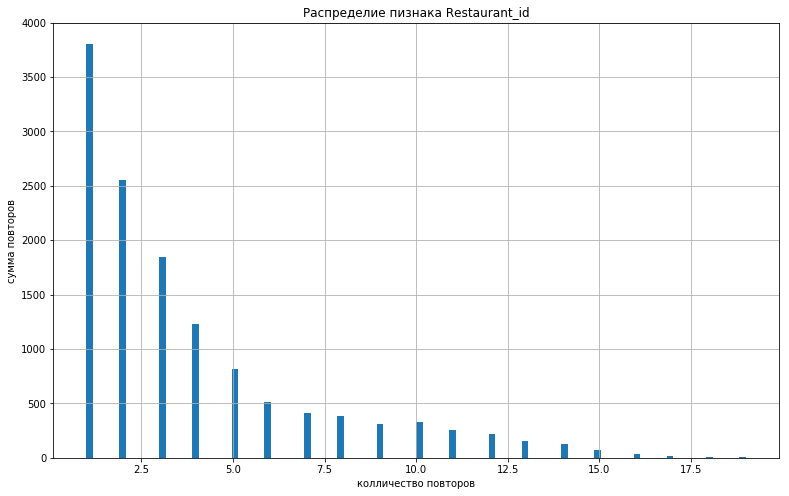

In [14]:
# Проверим распределение признака.
plt.rcParams['figure.figsize'] = (13,8)
ds = df['Restaurant_id'].value_counts().hist(bins=100)
ds.set_xlabel('колличество повторов')
ds.set_ylabel('сумма повторов')
ds.set_title('Распределие пизнака Restaurant_id')

In [15]:
# Этот столбец можно обработать, отделив "id_" от числовой части. df['Restaurant_id'] = df['Restaurant_id'].apply(lambda x: int(x[3:])),
# но эти преобразования не помогли улучшить модель.

### 2.2 ID_TA

In [16]:
# Есть еще одна колонка, в которой есть уникальные id рестаранов.
df['ID_TA'].value_counts()

d7337366     2
d9802625     2
d11999956    2
d11674463    2
d1568045     2
            ..
d10678894    1
d1536368     1
d12408044    1
d4451558     1
d8704187     1
Name: ID_TA, Length: 49963, dtype: int64

In [17]:
# Создадим новый признак, фактически дигетализируем ID_TA
df['ID_TA'] = df['ID_TA'].apply(lambda x: float(x[1:]))

### 2.3 URL_TA

In [18]:
# Здесь тоже есть повторения, проверим как они сопостовляются со ссылками на рестораны.
df['URL_TA'].value_counts()

/Restaurant_Review-g187514-d11698990-Reviews-Verdello_Restaurante-Madrid.html                     2
/Restaurant_Review-g187514-d11674463-Reviews-Beerhouse-Madrid.html                                2
/Restaurant_Review-g187514-d11999956-Reviews-SugarCane_Madrid-Madrid.html                         2
/Restaurant_Review-g187514-d1315077-Reviews-El_Pimiento_Verde-Madrid.html                         2
/Restaurant_Review-g187514-d9877640-Reviews-Raku_Sushi-Madrid.html                                2
                                                                                                 ..
/Restaurant_Review-g187514-d2724112-Reviews-EL_MIRADOR_DE_CEA-Madrid.html                         1
/Restaurant_Review-g187514-d991479-Reviews-El_Capricho-Madrid.html                                1
/Restaurant_Review-g186338-d3255457-Reviews-The_royal_inn_on_the_park-London_England.html         1
/Restaurant_Review-g188590-d7928571-Reviews-De_Patatzaak-Amsterdam_North_Holland_Province.html    1


In [19]:
# Из таблицы видно, что мы имеем дело с дубликатами ресторанов. Причем значение Ranking у них не одинаковые.
df[(df['URL_TA'].map(df['URL_TA'].value_counts()) == 2)].sort_values(by='ID_TA')

Restaurant_id    City  \
38096       id_1209  Madrid   
14578       id_1180  Madrid   
15240       id_2406  Madrid   
46822       id_2487  Madrid   
18019       id_2361  Madrid   
...             ...     ...   
26920       id_3536  Madrid   
1171        id_1171  Madrid   
48967       id_1238  Madrid   
36696       id_2485  Madrid   
11579       id_2673  Madrid   

                                           Cuisine Style  Ranking Price Range  \
38096  ['Moroccan', 'Vegetarian Friendly', 'Vegan Opt...   1210.0    $$ - $$$   
14578  ['Moroccan', 'Vegetarian Friendly', 'Vegan Opt...   1181.0    $$ - $$$   
15240                  ['Italian', 'French', 'European']   2408.0    $$ - $$$   
46822                  ['Italian', 'French', 'European']   2489.0    $$ - $$$   
18019  ['Seafood', 'Mediterranean', 'European', 'Span...   2363.0    $$ - $$$   
...                                                  ...      ...         ...   
26920  ['International', 'Mediterranean', 'Spanish', ...   3538.0    $$ - $$$   
1171   ['Indian', 'Asian', 'Nepali', 'Vegetarian Frie...   1219.0    $$ - $$$   
48967  ['Indian', 'Asian', 'Nepali', 'Vegetarian Frie...   1240.0    $$ - $$$   
36696                                       ['American']   2487.0           $   
11579                                       ['American']   2675.0           $   

       Number of Reviews                                            Reviews  \
38096              341.0  [['Great food, service and atmosphere', 'Decor...   
14578              341.0  [['Great food, service and atmosphere', 'Decor...   
15240              148.0  [['Sat night', 'Can\'t even explain.. "A" plac...   
46822              148.0  [['Sat night', 'Can\'t even explain.. "A" plac...   
18019              190.0  [['Nice restaurant in Madrid', 'Highly reccome...   
...                  ...                                                ...   
26920               52.0  [['Great Food! Wide Variety.', 'Dinner'], ['11...   
1171                22.0  [['Fantastic food, Excellent service', 'Surpri...   
48967               22.0  [['Fantastic food, Excellent service', 'Surpri...   
36696                6.0  [['Healthy vegan doughnuts are posible', 'Best...   
11579                6.0  [['Healthy vegan doughnuts are posible', 'Best...   

                                                  URL_TA       ID_TA  sample  \
38096  /Restaurant_Review-g187514-d697406-Reviews-Al_...    697406.0       1   
14578  /Restaurant_Review-g187514-d697406-Reviews-Al_...    697406.0       1   
15240  /Restaurant_Review-g187514-d793170-Reviews-Car...    793170.0       1   
46822  /Restaurant_Review-g187514-d793170-Reviews-Car...    793170.0       1   
18019  /Restaurant_Review-g187514-d987900-Reviews-Com...    987900.0       1   
...                                                  ...         ...     ...   
26920  /Restaurant_Review-g187514-d11999956-Reviews-S...  11999956.0       1   
1171   /Restaurant_Review-g187514-d12488993-Reviews-K...  12488993.0       0   
48967  /Restaurant_Review-g187514-d12488993-Reviews-K...  12488993.0       1   
36696  /Restaurant_Review-g187514-d13002276-Reviews-D...  13002276.0       1   
11579  /Restaurant_Review-g187514-d13002276-Reviews-D...  13002276.0       1   

       Rating  
38096     4.0  
14578     4.0  
15240     4.0  
46822     4.0  
18019     4.0  
...       ...  
26920     4.0  
1171      0.0  
48967     5.0  
36696     5.0  
11579     5.0  

[74 rows x 11 columns]

In [20]:
# Дупликаты представлены в основном в Мадриде, но есть и в Варшаве.
df[(df['URL_TA'].map(df['URL_TA'].value_counts()) == 2)].sort_values(by='ID_TA').City.value_counts()

Madrid    70
Warsaw     4
Name: City, dtype: int64

In [21]:
# В признаке URL_TA содержиться информация о названии ресторана, о ID_TA ресторана, а так же ID города. Попробуем поменять значение признака.
df['City_url_ta'] = df.URL_TA.str.findall(r"g([\s\S]+?)-").str[0]

### 2.4 Ranking

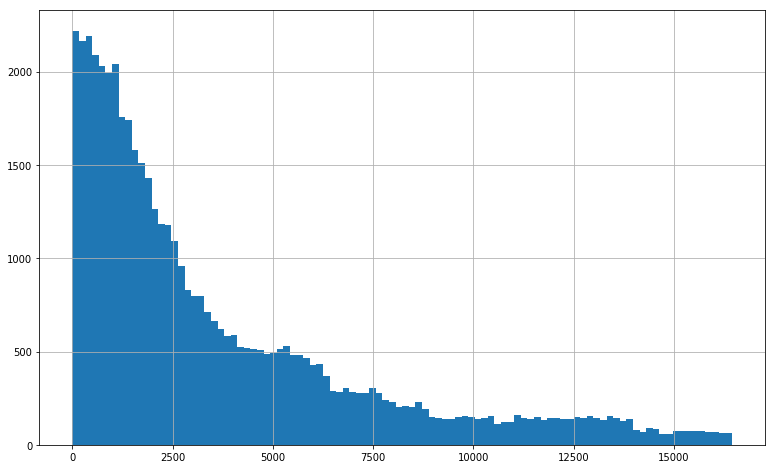

In [22]:
# Проверим распределение признака Ranking.
df['Ranking'].hist(bins=100)

Ниже число -  выше ранг. Он распределен между ресторанами в городе. Т.е. в каждом городе есть ресторан с наивысшим рангом, но не в каждом с большим числом. 

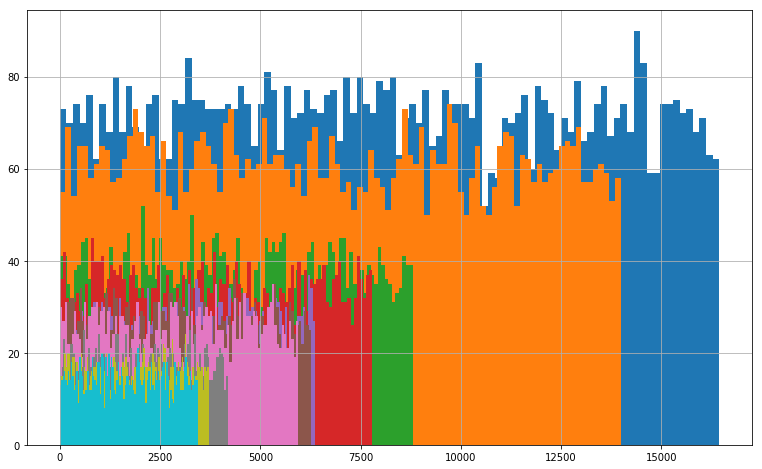

In [23]:
# На этом графике хорошо видно, что рейтинг нарямую зависит от колличества ресторанов в городе.
for x in (df['City'].value_counts())[0:10].index:
    df['Ranking'][df['City'] == x].hist(bins=100)
plt.show()

In [24]:
# Введем новую переменную, которая будет соответствовать количеству ресторанов в городе.
def ranking(df):
    reCount = df.City.value_counts()
    restCount = dict(reCount)
    df['DB_Restaurants_Count'] = df['City'].map(restCount)
    
    # Нормализуем данные так, что бы ранг ресторана не зависил от количества ресторанов в нем.
    mean_per_city = df.groupby('City')['Ranking'].mean()
    df['mean_ranking_per_city'] = df['City'].apply(lambda x: mean_per_city[x])
    max_per_city = df.groupby('City')['Ranking'].max()
    df['max_ranking_per_city'] = df['City'].apply(lambda x: max_per_city[x])
    df['standard_ranking'] = (df['Ranking'] - df['mean_ranking_per_city']) / df['max_ranking_per_city']
    
    return df

In [25]:
ranking(df).sample(5)

Restaurant_id       City                 Cuisine Style  Ranking  \
13391       id_6281     Madrid  ['Spanish', 'Mediterranean']   6284.0   
32592       id_8049     London        ['British', 'Turkish']   8058.0   
29800       id_5794       Rome                   ['Seafood']   5796.0   
6639        id_6639  Edinburgh                           NaN   1235.0   
35837       id_5993     Madrid                           NaN   5996.0   

      Price Range  Number of Reviews  \
13391           $               67.0   
32592           $                8.0   
29800        $$$$                NaN   
6639          NaN                4.0   
35837         NaN               11.0   

                                                 Reviews  \
13391  [['Excellent Locals Restaurant Bar', 'Much bet...   
32592  [['Relaxed welcoming coffee shop', 'great ambi...   
29800                                           [[], []]   
6639   [['Great hot chocolate, excellent pastries', '...   
35837  [['Average Chinese food, but convenient locat....   

                                                  URL_TA       ID_TA  sample  \
13391  /Restaurant_Review-g187514-d1511891-Reviews-Nu...   1511891.0       1   
32592  /Restaurant_Review-g186338-d10374742-Reviews-C...  10374742.0       1   
29800  /Restaurant_Review-g187791-d13196377-Reviews-P...  13196377.0       1   
6639   /Restaurant_Review-g186525-d12833260-Reviews-H...  12833260.0       0   
35837  /Restaurant_Review-g187514-d10810804-Reviews-K...  10810804.0       1   

       Rating City_url_ta  DB_Restaurants_Count  mean_ranking_per_city  \
13391     4.0      187514                  3813            4388.516391   
32592     4.5      186338                  7193            8169.707354   
29800     5.0      187791                  2589            2970.733102   
6639      0.0      186525                   745             885.130201   
35837     3.5      187514                  3813            4388.516391   

       max_ranking_per_city  standard_ranking  
13391                8809.0          0.215176  
32592               16444.0         -0.006793  
29800                5948.0          0.474994  
6639                 1766.0          0.198114  
35837                8809.0          0.182482

In [26]:
df.sample(5)

Restaurant_id       City                        Cuisine Style  Ranking  \
44866       id_1738   Brussels                           ['Fusion']   1739.0   
17210        id_531    Hamburg                             ['Cafe']    532.0   
6087        id_6087  Edinburgh  ['British', 'Scottish', 'European']   1097.0   
26537       id_6112  Barcelona                                  NaN   6113.0   
48254       id_5571      Paris                           ['French']   5572.0   

      Price Range  Number of Reviews  \
44866           $               14.0   
17210           $               14.0   
6087     $$ - $$$               69.0   
26537         NaN                2.0   
48254           $               33.0   

                                                 Reviews  \
44866  [['Quick delicious lunch', 'The perfect lunch'...   
17210  [['Excellent breakfast and brunch', 'Nice cozy...   
6087   [['Excellent food', 'Afternoon Tea'], ['12/30/...   
26537                                           [[], []]   
48254  [['Good, simple, home-made food', 'Une pause d...   

                                                  URL_TA       ID_TA  sample  \
44866  /Restaurant_Review-g1068497-d10522391-Reviews-...  10522391.0       1   
17210  /Restaurant_Review-g187331-d11659200-Reviews-M...  11659200.0       1   
6087   /Restaurant_Review-g186525-d2141711-Reviews-Cr...   2141711.0       0   
26537  /Restaurant_Review-g187497-d7677993-Reviews-Ca...   7677993.0       1   
48254  /Restaurant_Review-g187147-d3578267-Reviews-L_...   3578267.0       1   

       Rating City_url_ta  DB_Restaurants_Count  mean_ranking_per_city  \
44866     4.0     1068497                  1314            1541.901826   
17210     4.5      187331                  1186            1375.409781   
6087      0.0      186525                   745             885.130201   
26537     3.5      187497                  3395            3879.422680   
48254     4.5      187147                  6108            6938.557138   

       max_ranking_per_city  standard_ranking  
44866                3006.0          0.065568  
17210                2737.0         -0.308151  
6087                 1766.0          0.119972  
26537                7796.0          0.286503  
48254               13986.0         -0.097709

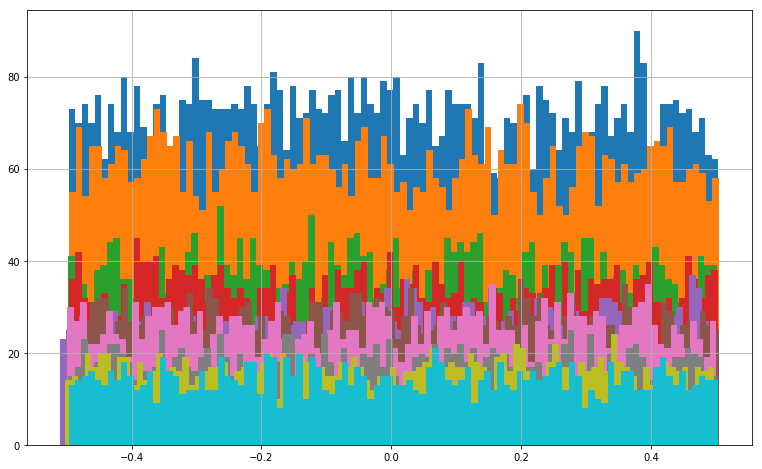

In [27]:
# посмотрим обновленое распределение для тех же городов
for x in (df['City'].value_counts())[0:10].index:
    df['standard_ranking'][df['City'] == x].hist(bins=100)
plt.show()

Смещение исчезло.

### 2.5 City

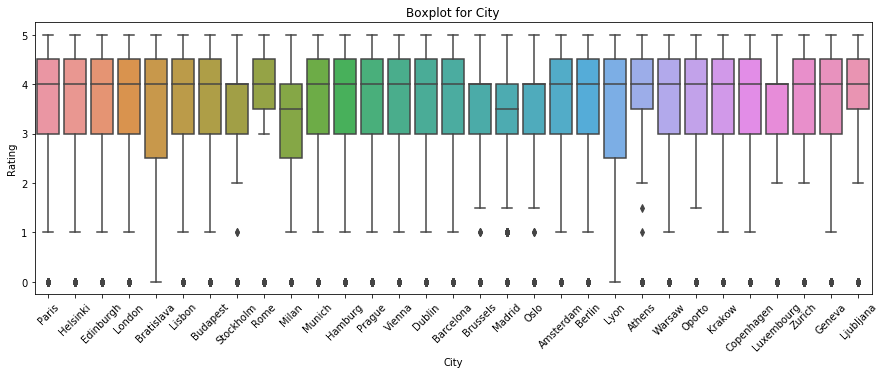

In [28]:
# Проверим распределение Rating по городам.
fig, ax = plt.subplots(figsize = (15, 5))

sns.boxplot(x='City', y='Rating',data=df.loc[
    df.loc[:, 'City'].isin(df.loc[:, 'City'].value_counts().index[:])
],ax=ax)

plt.xticks(rotation=45)
ax.set_title('Boxplot for City')

plt.show()

Сразу заметро выбиваются рестораны Рима. А так же отдельно можно выделить ресторвны Мадрида.

In [29]:
# Можно было бы выделить эти города. но в конце концов для улучшения модели они не пригодились
# df['is_Rome'] = df['City'].apply(lambda x: 1 if x == 'Rome' else 0)
# df['is_Madrid'] = df['City'].apply(lambda x: 1 if x == 'Helsinki' else 0)

In [30]:
# Можно было бы так же создать новый признак, в котором было бы отражено является город столицей или нет.
def capital(df):
    Capitals = [
        'Athens', 'Bratislava', 'London', 'Paris', 'Madrid', 'Berlin', 'Rome',
        'Prague', 'Lisbon', 'Vienna', 'Amsterdam', 'Brussels', 'Stockholm',
        'Budapest', 'Warsaw', 'Dublin', 'Copenhagen', 'Edinburgh', 'Oslo',
        'Helsinki', 'Luxembourg', 'Ljubljana'
    ]
    df['is_capital'] = df['City'].apply(lambda x: 1 if x in Capitals else 0)
    return df

<Figure size 360x360 with 0 Axes>

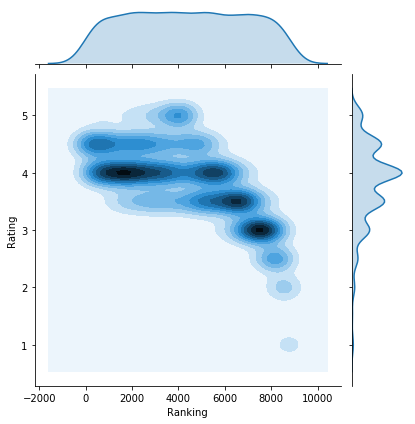

In [31]:
# Визуализируем распределение рейтинга по ранкам ресторанов в одном городе. Для примера возьмем самый
# типичный случвй - рестораны Мадрида.
plt.figure(figsize = (5,5))
sns.jointplot(data = df[(df.City == 'Madrid') & (df.Rating > 0)], x = 'Ranking', y = 'Rating', kind = 'kde')

In [32]:
# Распределение Ranking и Raiting напоминает морду коня. Когда рестораны с наивыйшим Ranking, получают 4-4.5
# Создадим признак, который на основании Ranking вычисляет значение Rating
max_ranking = df.groupby(['City']).Ranking.max()

df['rating_by_ranking'] = df.apply(new_ranking, axis = 1)
rating_by_ranking = df['rating_by_ranking']
rating_by_ranking.name = 'rating_by_ranking'

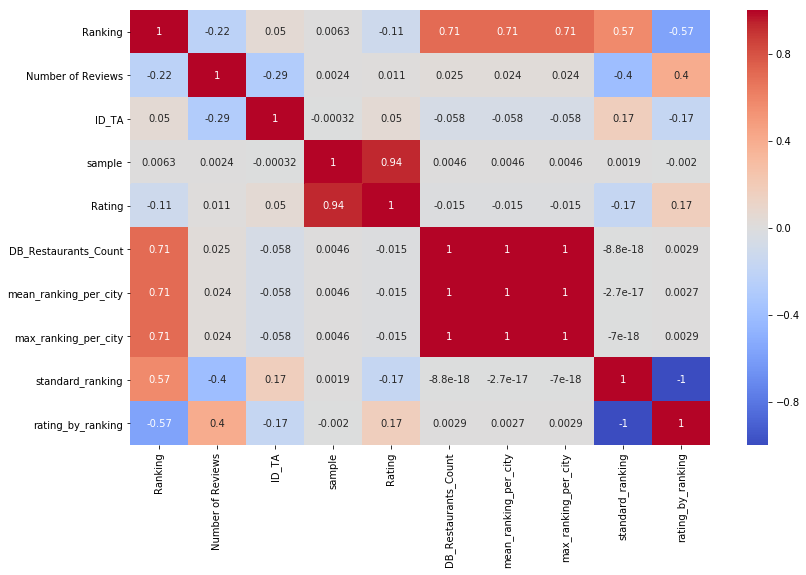

In [33]:
# Посмотрим на корреляционную матрицу.
ax = sns.heatmap(df.corr(),annot = True, cmap = 'coolwarm')

Заметна сильная негативная корреляция между ratind_by_ranking и standard_ranking. А так же положительная корреляция между mean_ranking_per_city и max_ranking_per_city а так же DB_Restaurants_Count. Из кажлой пары удаляем один признак.

In [34]:
# Добавим население города.
population = {
        'Paris': 2190327,
        'Stockholm': 961609,
        'London': 8908081,
        'Berlin': 3644826,
        'Munich': 1456039,
        'Oporto': 237591,
        'Milan': 1378689,
        'Bratislava': 432864,
        'Vienna': 1821582,
        'Rome': 4355725,
        'Barcelona': 1620343,
        'Madrid': 3223334,
        'Dublin': 1173179,
        'Brussels': 179277,
        'Zurich': 428737,
        'Warsaw': 1758143,
        'Budapest': 1752286,
        'Copenhagen': 615993,
        'Amsterdam': 857713,
        'Lyon': 506615,
        'Hamburg': 1841179,
        'Lisbon': 505526,
        'Prague': 1301132,
        'Oslo': 673469,
        'Helsinki': 643272,
        'Edinburgh': 488100,
        'Geneva': 200548,
        'Ljubljana': 284355,
        'Athens': 664046,
        'Luxembourg': 115227,
        'Krakow': 769498
    }

In [35]:
def city(df):
    
    # И создадим два признака. Население и количество ресторанов на человека в городе.
    df['Population'] = df['City'].map(population)
    # df['Restaurants_density'] = df['DB_Restaurants_Count'] / df['Population'] - не улучшил модель
    return df 

In [36]:
city(df).sample(3)

Restaurant_id    City  \
40029        id_247    Oslo   
27814       id_4285  London   
33263       id_1723  Dublin   

                                           Cuisine Style  Ranking Price Range  \
40029                                     ['Bar', 'Pub']    248.0    $$ - $$$   
27814  ['Mediterranean', 'Turkish', 'Delicatessen', '...   4292.0    $$ - $$$   
33263                                                NaN   1727.0         NaN   

       Number of Reviews                                            Reviews  \
40029               99.0  [['Great place to relax and have a beer', 'Wor...   
27814               26.0  [['Nice food and atmosphere', 'A Turkish Eater...   
33263                4.0  [["Small but cosy bar, cheap pints, I'll be b....   

                                                  URL_TA       ID_TA  sample  \
40029  /Restaurant_Review-g190479-d3384626-Reviews-Be...   3384626.0       1   
27814  /Restaurant_Review-g186338-d12165464-Reviews-M...  12165464.0       1   
33263  /Restaurant_Review-g186605-d3803369-Reviews-Ca...   3803369.0       1   

       Rating City_url_ta  DB_Restaurants_Count  mean_ranking_per_city  \
40029     4.0      190479                   488             552.569672   
27814     4.5      186338                  7193            8169.707354   
33263     3.0      186605                   836             972.127990   

       max_ranking_per_city  standard_ranking  rating_by_ranking  Population  
40029                1137.0         -0.267871                4.1      673469  
27814               16444.0         -0.235813                4.0     8908081  
33263                1960.0          0.385139                1.5     1173179

## 2.6 Price Range

In [37]:
df['Price Range'].value_counts()

$$ - $$$    23041
$            7816
$$$$         1782
Name: Price Range, dtype: int64

По описанию 'Price Range' это - Цены в ресторане.  
Их можно поставить по возрастанию (значит это не категориальный признак). А это значит, что их можно заменить последовательными числами, например 1,2,3  

In [38]:
# Заменяем пропущенные значения и меняем названия в ячейках для удобства. 
def price(df):
    prices = {'$': 1, '$$ - $$$': 2, '$$$$': 3, np.nan: 0}
    df['Price Range'] = df['Price Range'].replace(to_replace=prices)
    return df

In [39]:
price(df).sample(5)

Restaurant_id       City  \
24402       id_2523  Amsterdam   
6705        id_6705     London   
10480      id_14925     London   
6733        id_6733      Paris   
10686       id_2243  Stockholm   

                                           Cuisine Style  Ranking  \
24402                                        ['Mexican']   2530.0   
6705                           ['Bar', 'British', 'Pub']   6375.0   
10480  ['Bar', 'British', 'International', 'Vegetaria...  14936.0   
6733              ['Brew Pub', 'Bar', 'Pub', 'Wine Bar']   8060.0   
10686                            ['Pub', 'Scandinavian']   2247.0   

       Price Range  Number of Reviews  \
24402            2               34.0   
6705             2               37.0   
10480            2              319.0   
6733             2                2.0   
10686            2               86.0   

                                                 Reviews  \
24402  [['Best Mexican Restaurant around', 'Bad food'...   
6705   [['A really good pub!!', 'Great food, reasonab...   
10480  [['Convenient location', 'Interesting visit'],...   
6733   [['What a great joint!', 'Super bar- great amb...   
10686  [['OK for an afternoon drink', 'Mid evening ch...   

                                                  URL_TA       ID_TA  sample  \
24402  /Restaurant_Review-g188590-d753301-Reviews-Bur...    753301.0       1   
6705   /Restaurant_Review-g186338-d2525576-Reviews-Gr...   2525576.0       0   
10480  /Restaurant_Review-g186338-d2361013-Reviews-Th...   2361013.0       1   
6733   /Restaurant_Review-g187147-d11810616-Reviews-L...  11810616.0       0   
10686  /Restaurant_Review-g189852-d1043439-Reviews-So...   1043439.0       1   

       Rating City_url_ta  DB_Restaurants_Count  mean_ranking_per_city  \
24402     3.5      188590                  1372            1591.589650   
6705      0.0      186338                  7193            8169.707354   
10480     3.0      186338                  7193            8169.707354   
6733      0.0      187147                  6108            6938.557138   
10686     3.0      189852                  1033            1237.482091   

       max_ranking_per_city  standard_ranking  rating_by_ranking  Population  
24402                3254.0          0.288387                1.9      857713  
6705                16444.0         -0.109141                3.4     8908081  
10480               16444.0          0.411475                1.4     8908081  
6733                13986.0          0.080183                2.7     2190327  
10686                2464.0          0.409707                1.4      961609

### 2.7 Cuisine Style

In [40]:
def cuisine (df):
    # Приводим все названия кухонь к одному формату.
    df['Cuisine Style'] = df['Cuisine Style'].str.lower()

    # Делаем преобразования.
    cuisineStyle = set()
    df['Cuisine Style'].fillna('unknown_cuisine', inplace=True)
    cuisines = df['Cuisine Style'].to_list()

    # Заполняем сет для получения уникальных значений.
    # А так же создаем список
    for cuisine in cuisines:
        cuisine = re.findall(r"'([\s\S]+?)'", cuisine)
        for j in cuisine:
            cuisineStyle.add(j)
    
    for item in cuisineStyle:
        df[item] = df['Cuisine Style'].apply(lambda x: 1 if item in x else 0)
        df['cuisine'] = df['Cuisine Style'].apply(lambda x: 1 if x == 'None' else len(x.split(',')))
    return df

In [41]:
cuisine(df).sample(3)

Restaurant_id    City                               Cuisine Style  \
40413       id_7579  London  ['indian', 'halal', 'vegetarian friendly']   
35229       id_3478  Berlin                             unknown_cuisine   
27676       id_1436  Oporto           ['mediterranean', 'contemporary']   

       Ranking  Price Range  Number of Reviews  \
40413   7588.0            2               42.0   
35229   3480.0            0                NaN   
27676   1437.0            3                9.0   

                                                 Reviews  \
40413  [['INteresting curry', 'Excellent'], ['12/18/2...   
35229                                           [[], []]   
27676  [["It doesn't worth", 'Pleasant and relaxed. I...   

                                                  URL_TA      ID_TA  sample  \
40413  /Restaurant_Review-g186338-d8592661-Reviews-Ma...  8592661.0       1   
35229  /Restaurant_Review-g187323-d5520987-Reviews-Ra...  5520987.0       1   
27676  /Restaurant_Review-g189180-d953435-Reviews-Res...   953435.0       1   

       ...  slovenian new zealand  japanese  italian  mediterranean  \
40413  ...          0           0         0        0              0   
35229  ...          0           0         0        0              0   
27676  ...          0           0         0        0              1   

       cambodian  native american  argentinean  kosher  southwestern  
40413          0                0            0       0             0  
35229          0                0            0       0             0  
27676          0                0            0       0             0  

[3 rows x 144 columns]

# Подключение внешних данных

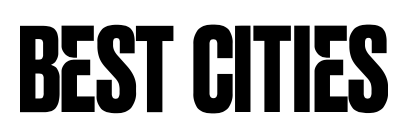

[Best cities](https://www.bestcities.org/rankings/worlds-best-cities/) by [Resonance](http://resonanceco.com/Reports/)

In [42]:
def load_best(df_input, best_input):
    # Объеденим данные.
    df2 = pd.merge(df_input, best_input, on='City', how='left')
    return df2

In [43]:
df = load_best(df, wd)

## TripAdvisor parsing:

По причине того, что мне еще сложно определить тон отзыва по тексту, решила достать оценки отзывов с сайта Trip Advisor при помощи парсинга. Признак "Reviews" удаляем.

Получили данные о количестве отзывов, заметили что многи рестораны пропали из базы данных TripAdvisor. Получили данные о последних 10 отзывах - даты и оценку.

In [44]:
# firsPage = df['URL_TA']
# firsPageUrl = df['URL_TA'].to_dict()
# firsPageUrl
# f = open("ffirsPageUrl.pkl","wb")
# pickle.dump(firsPageUrl,f)
# f.close()


# def getRaitings(r_id, url):
#     raitingsList = []
#     datesList = []
#     raitingsAutoD = {}
#     r = requests.get(url)
#     soup = BeautifulSoup(r.content)
#     nextLink = soup.find('link', rel='next')
#     if nextLink:
#         nextPage = nextLink.get('href')
#         if 'Restaurant_' in nextPage:
#             raiting = soup.find(
#                     'div', class_='listContainer hide-more-mobile').find_all(
#                         'span', {'class': 'ui_bubble_rating'})
#             dates = soup.find(
#                     'div', class_='listContainer hide-more-mobile').find_all(
#                         'span', class_='ratingDate')
#             raitNb = soup.find('span', class_ = '_3Wub8auF').get_text()
#             for i in raiting:
#                 i = i.get('class')
#                 raitingsList.append(i[1][7:8])
#             for j in dates:
#                 j = j.text
#                 datesList.append(j[9:])
#             raitingsAutoD[r_id] = datesList, raitingsList, raitNb
#             return raitingsAutoD
#         else:
#             raitingsList.append("Restaurant not found")
#             raitingsAutoD[r_id] = raitingsList
#             return raitingsAutoD
#     else:
#         raiting = soup.find(
#                 'div', class_='listContainer hide-more-mobile').find_all(
#                     'span', {'class': 'ui_bubble_rating'})
#         dates = soup.find(
#                 'div', class_='listContainer hide-more-mobile').find_all(
#                     'span', class_='ratingDate')
#         raitNb = soup.find('span', class_ = '_3Wub8auF').get_text()
#         for i in raiting:
#             i = i.get('class')
#             raitingsList.append(i[1][7:8])
#         for j in dates:
#             j = j.text
#             datesList.append(j[9:])
#         raitingsAutoD[r_id] = datesList, raitingsList, raitNb
#         return raitingsAutoD

# ddc = {}
# link = "https://www.tripadvisor.com"
# for k, v in firsPageUrl.items():
#     ddc[k] = getRaitings(k, link+v)

# f = open("parsedSite.pkl","wb")
# pickle.dump(parsedSite,f)
# f.close()

In [45]:
def load_TA(df_input, ta_input):
    # Вливаем новые данные в наш дата фрейм.
    df = pd.merge(df_input, ta_input, on='URL_TA', how ='left')
    return df

In [46]:
df = load_TA(df, df2)

In [47]:
df.sample(5)

Restaurant_id        City  \
30046        id_175  Luxembourg   
33487       id_3829        Rome   
28761       id_4048        Rome   
16541       id_1377   Stockholm   
3350        id_3350    Brussels   

                                           Cuisine Style  Ranking  \
30046                         ['steakhouse', 'european']    176.0   
33487                                    unknown_cuisine   3830.0   
28761                                        ['italian']   4049.0   
16541  ['swedish', 'scandinavian', 'fast food', 'euro...   1378.0   
3350     ['steakhouse', 'european', 'barbecue', 'grill']   2522.0   

       Price Range  Number of Reviews  \
30046            2               63.0   
33487            0               16.0   
28761            1               21.0   
16541            1               47.0   
3350             2               85.0   

                                                 Reviews  \
30046  [['A recommandable place !', 'Best horse steak...   
33487                                           [[], []]   
28761  [['Good bread for breakfast', 'Local reference...   
16541  [['Brunch was kinda disappointing', 'Perfect m...   
3350   [['Exquisit meat in an intimate, cosy atmosph....   

                                                  URL_TA       ID_TA  sample  \
30046  /Restaurant_Review-g190356-d743900-Reviews-Res...    743900.0       1   
33487  /Restaurant_Review-g187791-d8339164-Reviews-Lo...   8339164.0       1   
28761  /Restaurant_Review-g187791-d7342616-Reviews-Pa...   7342616.0       1   
16541  /Restaurant_Review-g189852-d10453186-Reviews-I...  10453186.0       1   
3350   /Restaurant_Review-g1136493-d2055806-Reviews-E...   2055806.0       0   

       ...  Time_dif2 Time_dif3  Time_dif4  Time_dif5  Time_dif6  Time_dif7  \
30046  ...        9.0     623.0       95.0       69.0      111.0       10.0   
33487  ...        NaN       NaN        NaN        NaN        NaN        NaN   
28761  ...       32.0      23.0      436.0      214.0       94.0      738.0   
16541  ...       33.0      59.0       64.0       50.0        1.0        8.0   
3350   ...        NaN       NaN        NaN        NaN        NaN        NaN   

       Time_dif8  Time_dif9  Time_dif10  Nr_of_Reviews  
30046      116.0        4.0      1228.0           78.0  
33487        NaN        NaN         NaN           32.0  
28761        NaN        NaN         NaN           28.0  
16541      309.0       25.0       550.0           82.0  
3350         NaN        NaN         NaN            NaN  

[5 rows x 174 columns]

### 2.8 Number of reviews

Соотвенно TripAdvisor, количество отзывов влияет на ранг рестора. Визуализируем эти данные.

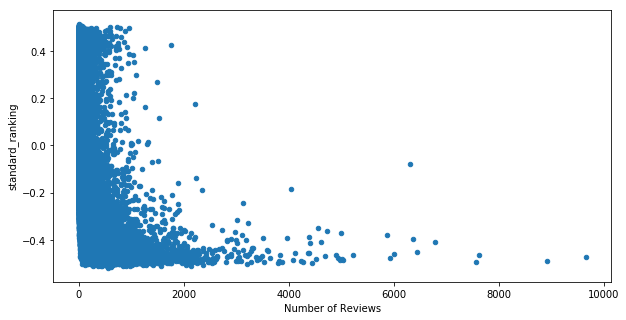

In [48]:
plt.rcParams['figure.figsize'] = (10.0, 5.0)
ax1 = df.plot.scatter(x='Number of Reviews',
                      y='standard_ranking')
ax1.xaxis.get_label().set_visible(True)

In [49]:
def number_of_reviews(df):

    # соответственно этому набдлюдению, заменяем пропущенные значения.
    df.standard_ranking = round(df.standard_ranking, 2)
    df['Number of Reviews'] = df.groupby(['standard_ranking'])['Number of Reviews'].apply(lambda x: x.fillna(x.mean()))
    return df

In [50]:
def edit_number_of_reviews(input_df):
    # all about number_of_reviews
    
    df = input_df.copy()
    scaler = StandardScaler()
    
        # средний ранкинг для каждого города
    mean_per_city = df.groupby('City')['Number of Reviews'].mean()
    df['mean_Number_of_Reviews_per_city'] = df['City'].apply(lambda x: mean_per_city[x])

    #  масмимальный ранкинг для каждого города
    max_per_city = df.groupby('City')['Number of Reviews'].max()
    df['max_Number_of_Reviews_per_city'] = df['City'].apply(lambda x: max_per_city[x])

    # стандартизация
    df['stand_Number_of_Reviews'] = (df['Ranking'] - df['mean_Number_of_Reviews_per_city']) / df['max_Number_of_Reviews_per_city']
    
    # количество отзывов на каждого человека в городе
    try:
        df['reviews_per_each_person'] = df['Number of Reviews'] / df['population']
    except:
        pass

    # среднее количество отзывов по городам
    reviews_per_city = df.groupby(by='City')['Number of Reviews'].mean()
    df['reviews_per_city'] = df['City'].apply(lambda x: reviews_per_city[x])
    
    try:
        df['reviews_per_each_person'] = scaler.fit_transform(df[['reviews_per_each_person']])
    except:
        pass
    
    return df

In [51]:
number_of_reviews(df).sample(2)

Restaurant_id    City  \
47461        id_306  Geneva   
39832       id_1990  Munich   

                                           Cuisine Style  Ranking  \
47461  ['asian', 'korean', 'barbecue', 'vegetarian fr...    308.0   
39832                                           ['cafe']   2006.0   

       Price Range  Number of Reviews  \
47461            2               47.0   
39832            1               36.0   

                                                 Reviews  \
47461  [['Korean food is the best!', 'Delicious korea...   
39832  [['A very strange way of dealing with Brunch',...   

                                                  URL_TA      ID_TA  sample  \
47461  /Restaurant_Review-g188057-d4379929-Reviews-K_...  4379929.0       1   
39832  /Restaurant_Review-g187309-d5793534-Reviews-Ba...  5793534.0       1   

       ...  Time_dif2 Time_dif3  Time_dif4  Time_dif5  Time_dif6  Time_dif7  \
47461  ...       15.0      20.0        9.0       84.0      163.0       21.0   
39832  ...        NaN       NaN        NaN        NaN        NaN        NaN   

       Time_dif8  Time_dif9  Time_dif10  Nr_of_Reviews  
47461       27.0       73.0       649.0           60.0  
39832        NaN        NaN         NaN            0.0  

[2 rows x 174 columns]

In [52]:
df['Number of Reviews'].isna().sum()

0

# 2.9 Nr_of_Reviews
Посмотрим как внешний признак Nr_of_Reviews коррелирует с Number of Reviews. Заменим пропущенные значения.

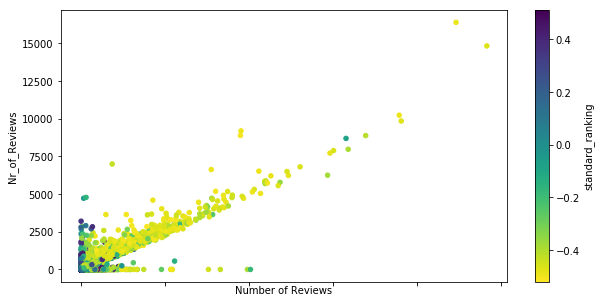

In [53]:
plt.rcParams['figure.figsize'] = (10.0, 5.0)
ax1 = df.plot.scatter(x='Number of Reviews',
                      y='Nr_of_Reviews',
                      c='standard_ranking',
                      colormap='viridis_r')
ax1.xaxis.get_label().set_visible(True)

На гравике видно, что рестораны с большим количеством отзывав стабильны, а тем что много отзывов не получают, или закрываются (0 на шкале Nr_of_Reviews), или так и остаются не популярными. Признак оказал прохое влияние на Public Score. Не будем использовать его.

## 2.10 Date_1

Date_1 - дата самого свежего отзыва. Посчитаем, актуальность последних отзывов.


In [54]:
def date_1(df):
    df['date_1'] = pd.to_datetime(df.date_1)

    today = pd.to_datetime(1605916800, unit='s')
    df['date_diff_newest'] = abs(df.date_1 - today).dt.days
    # Посмитаем разнвцу во времени для всех ресторанов.
    df['Calculated_Time_dif'] = round(df.Ranking/df['date_diff_newest'].max(), 2)
    return df

In [55]:
date_1(df).sample(5)

Restaurant_id    City  \
38876       id_1678  London   
13803        id_719  Munich   
27304      id_13978   Paris   
1407        id_1407  London   
49838         id_59  Warsaw   

                                           Cuisine Style  Ranking  \
38876  ['bar', 'british', 'pub', 'vegetarian friendly...   1681.0   
13803                                    unknown_cuisine    727.0   
27304                                         ['french']  13986.0   
1407   ['african', 'moroccan', 'middle eastern', 'hal...   2154.0   
49838  ['italian', 'mediterranean', 'european', 'vege...     60.0   

       Price Range  Number of Reviews  \
38876            2         158.000000   
13803            0          12.000000   
27304            0          32.622517   
1407             2         143.000000   
49838            2         277.000000   

                                                 Reviews  \
38876  [['Delicious Sunday roast', 'Great live music'...   
13803  [['Excellent and tasty sashimi, rolls, and ra....   
27304                                           [[], []]   
1407   [['Fantastic ambience', 'Out with family & fri...   
49838  [['Amazing food', 'Phenomenal!'], ['01/10/2018...   

                                                  URL_TA       ID_TA  sample  \
38876  /Restaurant_Review-g186338-d3568372-Reviews-Th...   3568372.0       1   
13803  /Restaurant_Review-g187309-d12449962-Reviews-Y...  12449962.0       1   
27304  /Restaurant_Review-g187147-d719135-Reviews-Le_...    719135.0       1   
1407   /Restaurant_Review-g186338-d720649-Reviews-Tag...    720649.0       0   
49838  /Restaurant_Review-g274856-d3537921-Reviews-Dz...   3537921.0       1   

       ...  Time_dif4 Time_dif5  Time_dif6  Time_dif7  Time_dif8  Time_dif9  \
38876  ...        0.0       0.0      241.0       14.0       27.0        0.0   
13803  ...       95.0      76.0       29.0       27.0      211.0       11.0   
27304  ...        NaN       NaN        NaN        NaN        NaN        NaN   
1407   ...        NaN       NaN        NaN        NaN        NaN        NaN   
49838  ...       17.0      87.0       43.0       40.0       39.0       43.0   

       Time_dif10  Nr_of_Reviews  date_diff_newest  Calculated_Time_dif  
38876       296.0          236.0              20.0                 0.28  
13803       576.0           55.0             323.0                 0.12  
27304         NaN            0.0            2927.0                 2.31  
1407          NaN            NaN               NaN                 0.36  
49838       483.0          427.0              90.0                 0.01  

[5 rows x 176 columns]

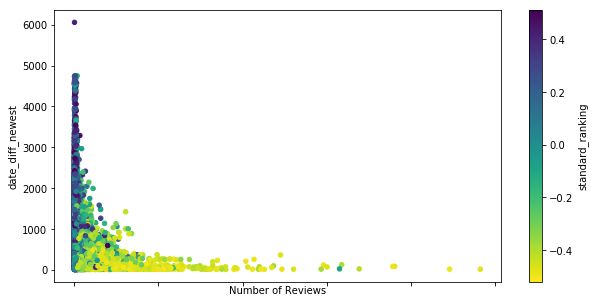

In [56]:
# Проверим зависимость времени последнего отзыва, от ранга и количества отзывов. Видно, что актуальность отзыва
# имеет большое значение на ранг ресторана.
plt.rcParams['figure.figsize'] = (10.0, 5.0)
ax1 = df.plot.scatter(y='date_diff_newest',
                      x='Number of Reviews',
                      c='standard_ranking',
                      colormap='viridis_r')
ax1.xaxis.get_label().set_visible(True)

## 2.11 review_stars

Оценки за последние 10 отзывов.

In [57]:
#  К сожалению. этот признак имел плохое влияние на Public Score.
# Не будем включать его в модель.
def review_stars(df):
    review_stars = set()
    df['Review_stars'].fillna('None', inplace=True)
    df.isnull().sum()
    stars = df['Review_stars'].to_list()

    for star in stars:
        star = re.findall(r"'([\s\S]+?)'", star)
        for j in star:
            review_stars.add(j)
    len(review_stars)

    for item in review_stars:
        df[item] = df['Review_stars'].apply(lambda x: 1 if item in x else 0)

    df['star'] = df['Review_stars'].apply(lambda x: 1 if x == 'None' else len(x.split(',')))
    return df

In [58]:
review_stars(df).sample(5)

Restaurant_id       City  \
35070       id_2055      Paris   
16191       id_2406     Munich   
36182       id_1520  Barcelona   
23374       id_2797     London   
18824        id_135   Helsinki   

                                           Cuisine Style  Ranking  \
35070     ['asian', 'vietnamese', 'vegetarian friendly']   2056.0   
16191                ['cafe', 'delicatessen', 'healthy']   2423.0   
36182  ['mexican', 'latin', 'fast food', 'central ame...   1521.0   
23374  ['chinese', 'fast food', 'asian', 'fusion', 'v...   2802.0   
18824  ['korean', 'asian', 'japanese', 'vietnamese', ...    136.0   

       Price Range  Number of Reviews  \
35070            2              158.0   
16191            2                5.0   
36182            1              147.0   
23374            1              202.0   
18824            2               58.0   

                                                 Reviews  \
35070  [['Where Việt foodies go for phở and other au....   
16191                  [['Smart caffè'], ['09/24/2016']]   
36182  [['Great food', 'Great burritos!'], ['12/13/20...   
23374  [['Good and cheap', 'Eat in'], ['09/23/2017', ...   
18824  [['Great place, recommended', 'Uneven, but qui...   

                                                  URL_TA       ID_TA  sample  \
35070  /Restaurant_Review-g187147-d10089103-Reviews-P...  10089103.0       1   
16191  /Restaurant_Review-g187309-d3354507-Reviews-Ba...   3354507.0       1   
36182  /Restaurant_Review-g187497-d10380871-Reviews-G...  10380871.0       1   
23374  /Restaurant_Review-g186338-d2190971-Reviews-Wo...   2190971.0       1   
18824  /Restaurant_Review-g189934-d12482248-Reviews-K...  12482248.0       1   

       ...  Time_dif10 Nr_of_Reviews  date_diff_newest  Calculated_Time_dif  \
35070  ...       393.0         316.0             298.0                 0.34   
16191  ...         NaN           0.0            1519.0                 0.40   
36182  ...       355.0         237.0             190.0                 0.25   
23374  ...       543.0         229.0             160.0                 0.46   
18824  ...       222.0          92.0             687.0                 0.02   

       4  3  1  2  5  star  
35070  1  0  1  0  1    10  
16191  0  1  0  0  0     1  
36182  1  1  0  0  1    10  
23374  1  1  1  0  1    10  
18824  1  1  0  1  1    10  

[5 rows x 182 columns]

## 2.12 Place, Programming, Product, People, Prosperity, Promotion

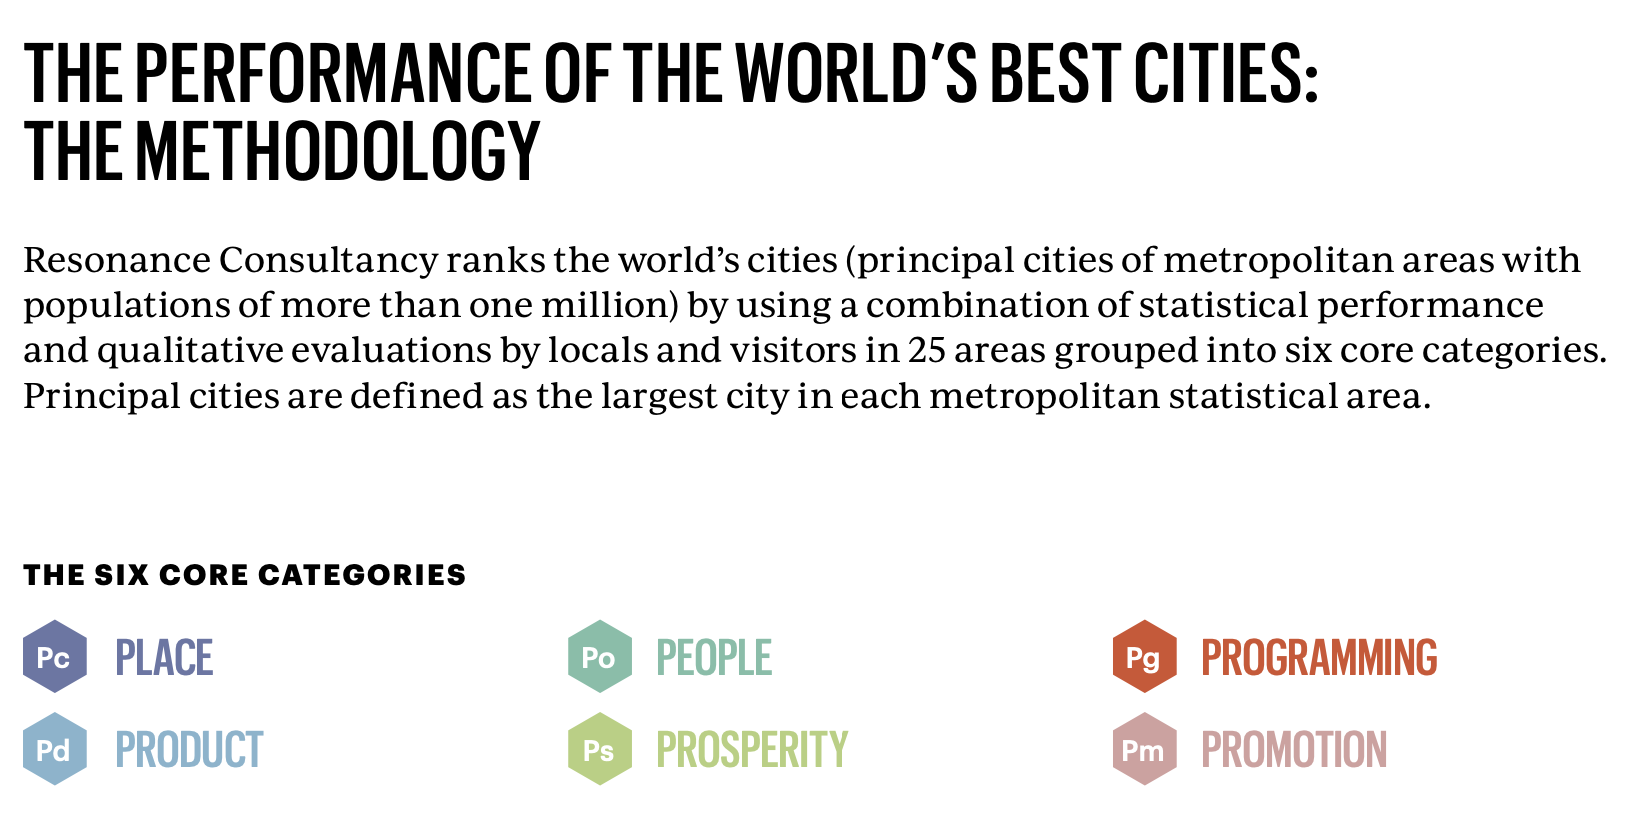

In [59]:
# Присвоим пустым значениям число 101 - за пределами первых 100 мест.
def best_cities(df):
    df.Rank.fillna(101, inplace=True)
    df['Place'] = df['Place'].fillna(df['Place'].mean())
    df['Programming'] = df['Programming'].fillna(df['Programming'].mean())
    df['Product'] = df['Product'].fillna(df['Product'].mean())
    df['People'] = df['People'].fillna(df['People'].mean())
    df['Prosperity'] = df['Prosperity'].fillna(df['Prosperity'].mean())
    df['Promotion'] = df['Promotion'].fillna(df['Promotion'].mean())
    return df

In [60]:
best_cities(df).sample(2)

Restaurant_id      City    Cuisine Style  Ranking  Price Range  \
23498       id_3934    Madrid  unknown_cuisine   3936.0            0   
18175       id_1650  Budapest   ['vietnamese']   1651.0            0   

       Number of Reviews                                            Reviews  \
23498               14.0                                           [[], []]   
18175                2.0  [['Translation problems', 'THIS IS REAL VIET F...   

                                                  URL_TA      ID_TA  sample  \
23498  /Restaurant_Review-g187514-d5776298-Reviews-El...  5776298.0       1   
18175  /Restaurant_Review-g274887-d2411088-Reviews-Lo...  2411088.0       1   

       ...  Time_dif10 Nr_of_Reviews  date_diff_newest  Calculated_Time_dif  \
23498  ...         NaN          17.0             364.0                 0.65   
18175  ...         NaN           0.0            3241.0                 0.27   

       4  3  1  2  5  star  
23498  0  0  0  0  1     1  
18175  1  0  0  0  1     2  

[2 rows x 182 columns]

## 2.13 Another variables

In [61]:
# Добавим еще несколько переменных
def another_var(df):
    mean_rews_by_city = round((df.groupby(['City'])['Number of Reviews'].sum() /
                               df.groupby(['City'])['Ranking'].max()), 2)
    mean_rews = df.City.apply(lambda x: mean_rews_by_city[x])
    mean_rews.name = 'Mean_rews'
    df = pd.concat([df, mean_rews],axis=1)

    df['Rating_RevNr2'] = df.Ranking * df['Number of Reviews']+1
    df['Rating_RevNr'] = df.standard_ranking * df['Number of Reviews']+1
    df['rel_numberOfRws'] = (df.standard_ranking)/(df.Ranking)
    return df

In [62]:
df = another_var(df)

In [63]:
another_var(df).sample(2)

Restaurant_id       City  \
37239        id_190  Stockholm   
41897      id_14327     London   

                                           Cuisine Style  Ranking  \
37239  ['lebanese', 'middle eastern', 'vegetarian fri...    191.0   
41897        ['japanese', 'sushi', 'asian', 'fast food']  14338.0   

       Price Range  Number of Reviews  \
37239            2              117.0   
41897            2               26.0   

                                                 Reviews  \
37239  [['Great meal', 'Excellent lunch buffet!!'], [...   
41897  [['So good! Fresh! Delicious!', 'take away'], ...   

                                                  URL_TA      ID_TA  sample  \
37239  /Restaurant_Review-g189852-d3678787-Reviews-Ta...  3678787.0       1   
41897  /Restaurant_Review-g186338-d1018807-Reviews-Fe...  1018807.0       1   

       ...  3  1  2  5  star  Mean_rews  Rating_RevNr2  Rating_RevNr  \
37239  ...  0  0  0  1    10      30.28        22348.0        -48.14   
41897  ...  1  0  1  1    10      57.64       372789.0         10.88   

       rel_numberOfRws  Mean_rews  
37239        -0.002199      30.28  
41897         0.000027      57.64  

[2 rows x 187 columns]

## 2.14 Reviews

In [64]:
# Видно, что формально у нас есть пропуски, о которых df.info() нам ничего не сказал.
# Так же, есть возможность получить даты оставленных отзывов.
df.Reviews.value_counts()

[[], []]                                                                                                        8112
[['Improve your service', 'Great value chain restaurant'], ['12/14/2017', '07/30/2017']]                           2
[['Healthy vegan doughnuts are posible', 'Best Vegan Donut in the world !!!'], ['11/17/2017', '11/16/2017']]       2
[['ok for beer, not for dinner'], ['12/20/2017']]                                                                  2
[['Great coffee and pastries, sandwiches, ver...', 'Great breakfast!'], ['02/21/2017', '09/19/2016']]              2
                                                                                                                ... 
[['Great Value Carvery', 'Great Sunday Carvery'], ['11/20/2017', '11/19/2017']]                                    1
[['Great cosy place!', 'Super yummy and chilled'], ['12/12/2017', '12/09/2017']]                                   1
[['Outstanding Pizza', 'Goede pasta'], ['12/15/2017', '06/25/201

In [65]:
def reviews(df):
    # заменим пропуски
    df['Reviews'] = df['Reviews'].apply(lambda x: None if x == '[[], []]' else x)

    # сперва выпишем ревью отдельно
    df['review_1'] = df['Reviews'].str.findall(r"'([\w\s]*)'").str[0]
    df['review_2'] = df['Reviews'].str.findall(r"'([\w\s]*)'").str[1]

    # теперь поработаем с датами
    df['date_a'] = df['Reviews'].str.findall(r"'([\d\/]*)'").str[0]
    df['date_b'] = df['Reviews'].str.findall(r"'([\d\/]*)'").str[1]

    df['Reviews'].str.findall(r"'([\d\/]*)'").str[1].str.len().value_counts(dropna=False)

    # совокупно, мы имеем много пропусков и небольшое количество строк, где данные не вписываются в формат дат.
    # для удобства работы, давайте пока заполним пропуски и неформатные строки каким нибудь специальным значением.
    df.loc[(df.date_a.str.len() < 10) | (df.date_a.isna()), 'date_a'] = None
    df.loc[(df.date_b.str.len() < 10) | (df.date_b.isna()), 'date_b'] = None

    ## и теперь приведем всё к привычному datetime виду
    df.date_a = pd.to_datetime(df.date_a)
    df.date_b = pd.to_datetime(df.date_b)

    df['is_eve'] = ((df.date_a.dt.month_name().isin(['December', 'January'])) | (df.date_b.dt.month_name().isin(['December', 'January']))).astype(int)
    df['year_a'] = df.date_a.dt.year
    df['year_b'] = df.date_b.dt.year
    df['date_diff'] = abs(df.date_a - df.date_b).dt.days

    df['review_1_len'] = df.review_1.str.len()
    df['review_2_len'] = df.review_2.str.len()
    
    df['review_1_len'] = df.review_1_len.fillna(0)
    df['review_2_len'] = df.review_2_len.fillna(0)
    
    df['year_a'] = df.year_a.fillna(0)
    df['year_b'] = df.year_b.fillna(0)
    
    df['date_diff'] = df.date_diff.fillna(0)
    
    return df

In [66]:
df = reviews(df)

In [67]:
df.sample(5)

Restaurant_id        City  \
927          id_927       Paris   
950          id_950     Hamburg   
27390       id_1563  Copenhagen   
37296        id_905      Madrid   
11759       id_2278     Hamburg   

                                           Cuisine Style  Ranking  \
927        ['french', 'european', 'vegetarian friendly']   1071.0   
950    ['turkish', 'middle eastern', 'mediterranean',...    281.0   
27390                                           ['thai']   1566.0   
37296            ['peruvian', 'latin', 'south american']    906.0   
11759                                    unknown_cuisine   2282.0   

       Price Range  Number of Reviews  \
927              2              204.0   
950              1               89.0   
27390            2                8.0   
37296            2              279.0   
11759            0               16.0   

                                                 Reviews  \
927    [['I strongly recommend this place', 'Nice sur...   
950    [['very good', 'Authentic Turkish restaurant']...   
27390  [['Very good, not expensive Thai', 'Authentic ...   
37296  [['Ceviche Yum', 'Hola de Peru'], ['11/19/2017...   
11759  [['Nice dinner', 'Great food and Atmosphere'],...   

                                                  URL_TA      ID_TA  sample  \
927    /Restaurant_Review-g187147-d942681-Reviews-Tie...   942681.0       0   
950    /Restaurant_Review-g187331-d4226553-Reviews-OZ...  4226553.0       0   
27390  /Restaurant_Review-g189541-d1385877-Reviews-Th...  1385877.0       1   
37296  /Restaurant_Review-g187514-d4823824-Reviews-La...  4823824.0       1   
11759  /Restaurant_Review-g187331-d959085-Reviews-Dia...   959085.0       1   

       ...                         review_1                      review_2  \
927    ...  I strongly recommend this place                 Nice surprise   
950    ...                        very good  Authentic Turkish restaurant   
27390  ...              Authentic thai food                           NaN   
37296  ...                      Ceviche Yum                  Hola de Peru   
11759  ...                      Nice dinner     Great food and Atmosphere   

          date_a     date_b  is_eve  year_a  year_b  date_diff  review_1_len  \
927   2017-06-10 2017-04-28       0  2017.0  2017.0       43.0          31.0   
950   2017-07-29 2017-12-29       1  2017.0  2017.0      153.0           9.0   
27390 2017-10-14 2017-01-18       1  2017.0  2017.0      269.0          19.0   
37296 2017-11-19 2017-08-24       0  2017.0  2017.0       87.0          11.0   
11759 2016-06-29 2015-07-02       0  2016.0  2015.0      363.0          11.0   

       review_2_len  
927            13.0  
950            28.0  
27390           0.0  
37296          12.0  
11759          25.0  

[5 rows x 196 columns]

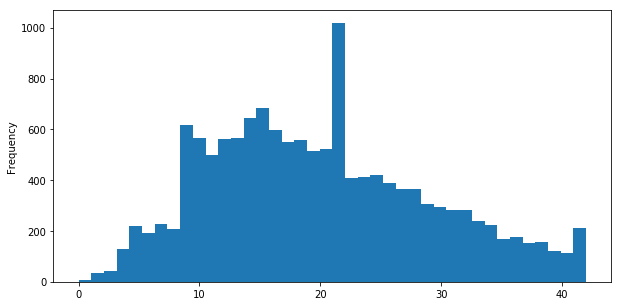

In [68]:
### Давайте посмотрим, в какой у нас диапазон длин комментариев
df = reviews(df)
df.review_2.str.len().plot(kind='hist', bins=40);

In [69]:
df.sample(5)

Restaurant_id       City  \
5724        id_5724     Athens   
39574        id_363       Oslo   
44087       id_7597  Barcelona   
41743        id_933    Hamburg   
44526      id_12832     London   

                                           Cuisine Style  Ranking  \
5724                                     unknown_cuisine    596.0   
39574  ['bar', 'pub', 'european', 'norwegian', 'veget...    364.0   
44087                                    unknown_cuisine   7598.0   
41743                                           ['cafe']    935.0   
44526                       ['mediterranean', 'turkish']  12842.0   

       Price Range  Number of Reviews  \
5724             0          11.000000   
39574            2          54.000000   
44087            0          35.022843   
41743            0           7.000000   
44526            0           4.000000   

                                                 Reviews  \
5724                                                None   
39574  [['Nice bar for smaller partys', 'An ok place ...   
44087                                               None   
41743                                               None   
44526  [['A delicious meze', 'very expensive!!!!!'], ...   

                                                  URL_TA       ID_TA  sample  \
5724   /Restaurant_Review-g189400-d11774289-Reviews-C...  11774289.0       0   
39574  /Restaurant_Review-g190479-d5454087-Reviews-Ay...   5454087.0       1   
44087  /Restaurant_Review-g187497-d11913689-Reviews-B...  11913689.0       1   
41743  /Restaurant_Review-g187331-d8713938-Reviews-Ca...   8713938.0       1   
44526  /Restaurant_Review-g186338-d8306658-Reviews-Ci...   8306658.0       1   

       ...                     review_1              review_2     date_a  \
5724   ...                         None                  None        NaT   
39574  ...  Nice bar for smaller partys  An ok place to drink 2017-11-07   
44087  ...                         None                  None        NaT   
41743  ...                         None                  None        NaT   
44526  ...             A delicious meze                   NaN 2015-12-22   

          date_b  is_eve  year_a  year_b  date_diff  review_1_len  \
5724         NaT       0     0.0     0.0        0.0           0.0   
39574 2017-01-16       1  2017.0  2017.0      295.0          27.0   
44087        NaT       0     0.0     0.0        0.0           0.0   
41743        NaT       0     0.0     0.0        0.0           0.0   
44526 2015-10-29       1  2015.0  2015.0       54.0          16.0   

       review_2_len  
5724            0.0  
39574          20.0  
44087           0.0  
41743           0.0  
44526           0.0  

[5 rows x 196 columns]

### Посмотрим распределение целевой переменной

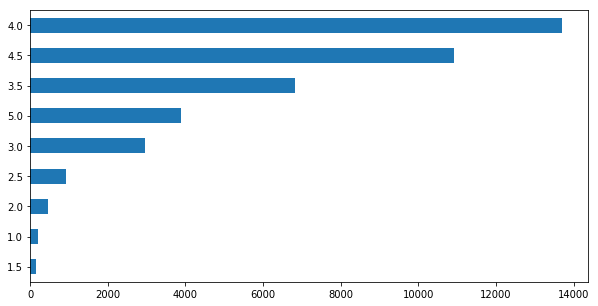

In [70]:
df_train['Rating'].value_counts(ascending=True).plot(kind='barh')

### Посмотрим распределение целевой переменной относительно признака

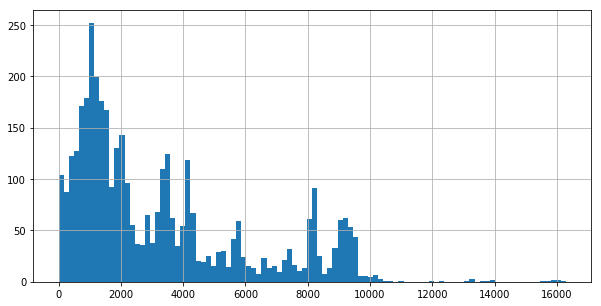

In [71]:
df_train['Ranking'][df_train['Rating'] == 5].hist(bins=100)

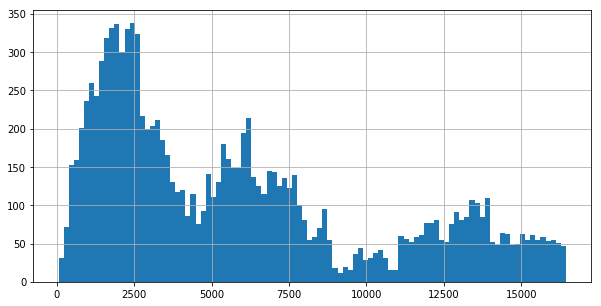

In [72]:
df_train['Ranking'][df_train['Rating'] < 4].hist(bins=100)

# Data Preprocessing

In [73]:
#На всякий случай перегружаем данные еще раз
DATA_DIR = '/kaggle/input/sf-dst-restaurant-rating/'
df_train = pd.read_csv(DATA_DIR+'/main_task.csv')
df_test = pd.read_csv(DATA_DIR+'kaggle_task.csv')
sample_submission = pd.read_csv(DATA_DIR+'/sample_submission.csv')
wd = pd.read_excel('/kaggle/input/module3/world.xlsx')
df2 = pd.read_csv('/kaggle/input/ptripadvisor/pTA.csv')

df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

df = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

In [74]:
def preproc_data(df_input):
    '''includes several functions to pre-process the predictor data.'''
        
    df = df_input.copy()
    
    ############################## 2.1 Restaurant_id  ###########################
    df['Restaurant_id'] = df['Restaurant_id'].apply(lambda x: int(x[3:]))
    
    ############################## 2.2 ID_TA  ################################### 
    df['ID_TA'] = df['ID_TA'].apply(lambda x: int(x[1:]))
    
    ############################## 2.3 URL_TA  ################################### 
    df['City_url_ta'] = df.URL_TA.str.findall(r"g([\s\S]+?)-").str[0]
    
    ############################## 2.4 Ranking  #################################      
    df = ranking(df)
    
    ############################## 2.5 City   ###################################
    df = city(df)
    df = capital(df)
    
    ############################## 2.6 Price Range   ############################
    df = price(df)
    
    ############################## 2.7 Cuisine style ############################
    df = cuisine(df)
    
    ############################## 2.8 Number of Reviews  #######################
    df = number_of_reviews(df)
    df = edit_number_of_reviews(df)
    
    ############################## Подключение внешних данных  ##################
    df = load_best(df, wd)
    df = load_TA(df, df2)
    
    ############################## 2.10 Date_1  #################################
    df = date_1(df)
    
    
    ######## 2.12 Place, Programming, Product, People, Prosperity, Promotion  ###
    df = best_cities(df)

    
    ########################## 2.13 Another variables  ##########################
    df = another_var(df)
    
    ########################## 2.14 reviews  ####################################
    df = reviews(df)
    
    return df

#### Запускаем и проверяем что получилось

In [75]:
df_preproc = preproc_data(df)
df_preproc.sample(2)

Restaurant_id    City  \
40725            760  London   
5463            5463  Munich   

                                           Cuisine Style  Ranking  \
40725  ['indian', 'asian', 'vegetarian friendly', 've...    761.0   
5463   ['italian', 'pizza', 'european', 'mediterranea...    496.0   

       Price Range  Number of Reviews  \
40725            3              962.0   
5463             1               81.0   

                                                 Reviews  \
40725  [['pricy but good', 'Best tasting good but ver...   
5463   [['Simple Great Pizza in Munich', 'Great littl...   

                                                  URL_TA   ID_TA  sample  ...  \
40725  /Restaurant_Review-g186338-d720053-Reviews-Min...  720053       1  ...   
5463   /Restaurant_Review-g187309-d808968-Reviews-Gra...  808968       0  ...   

                           review_1                           review_2  \
40725                pricy but good  Best tasting good but very pricey   
5463   Simple Great Pizza in Munich                                NaN   

          date_a     date_b  is_eve  year_a  year_b  date_diff  review_1_len  \
40725 2018-01-08 2018-01-07       1  2018.0  2018.0        1.0          14.0   
5463  2017-04-15 2017-07-17       0  2017.0  2017.0       93.0          28.0   

       review_2_len  
40725          33.0  
5463            0.0  

[2 rows x 194 columns]

In [76]:
df_preproc = df_preproc.drop(columns=[
 'Cuisine Style',
 'City',
 'Restaurant_id',
 'date_1',
 'date_2',
 'date_3',
 'date_4',
 'date_5',
 'date_6',
 'date_7',
 'date_8',
 'date_9',
 'date_10',
 'Time_dif1',
 'Time_dif2',
 'Time_dif3',
 'Time_dif4',
 'Time_dif5',
 'Time_dif6',
 'Time_dif7',
 'Time_dif8',
 'Time_dif9',
 'Time_dif10',
 'Nr_of_Reviews',
 'date_diff_newest',
 'Review_stars',
 'Reviews', 
 'max_ranking_per_city', 
 'mean_ranking_per_city',
 'date_a', 
 'date_b', 
 'review_1', 
 'review_2',
])

### [Корреляция признаков](https://ru.wikipedia.org/wiki/Корреляция)
На этом графике уже сейчас вы можно заметить, как признаки связаны между собой и с целевой переменной.

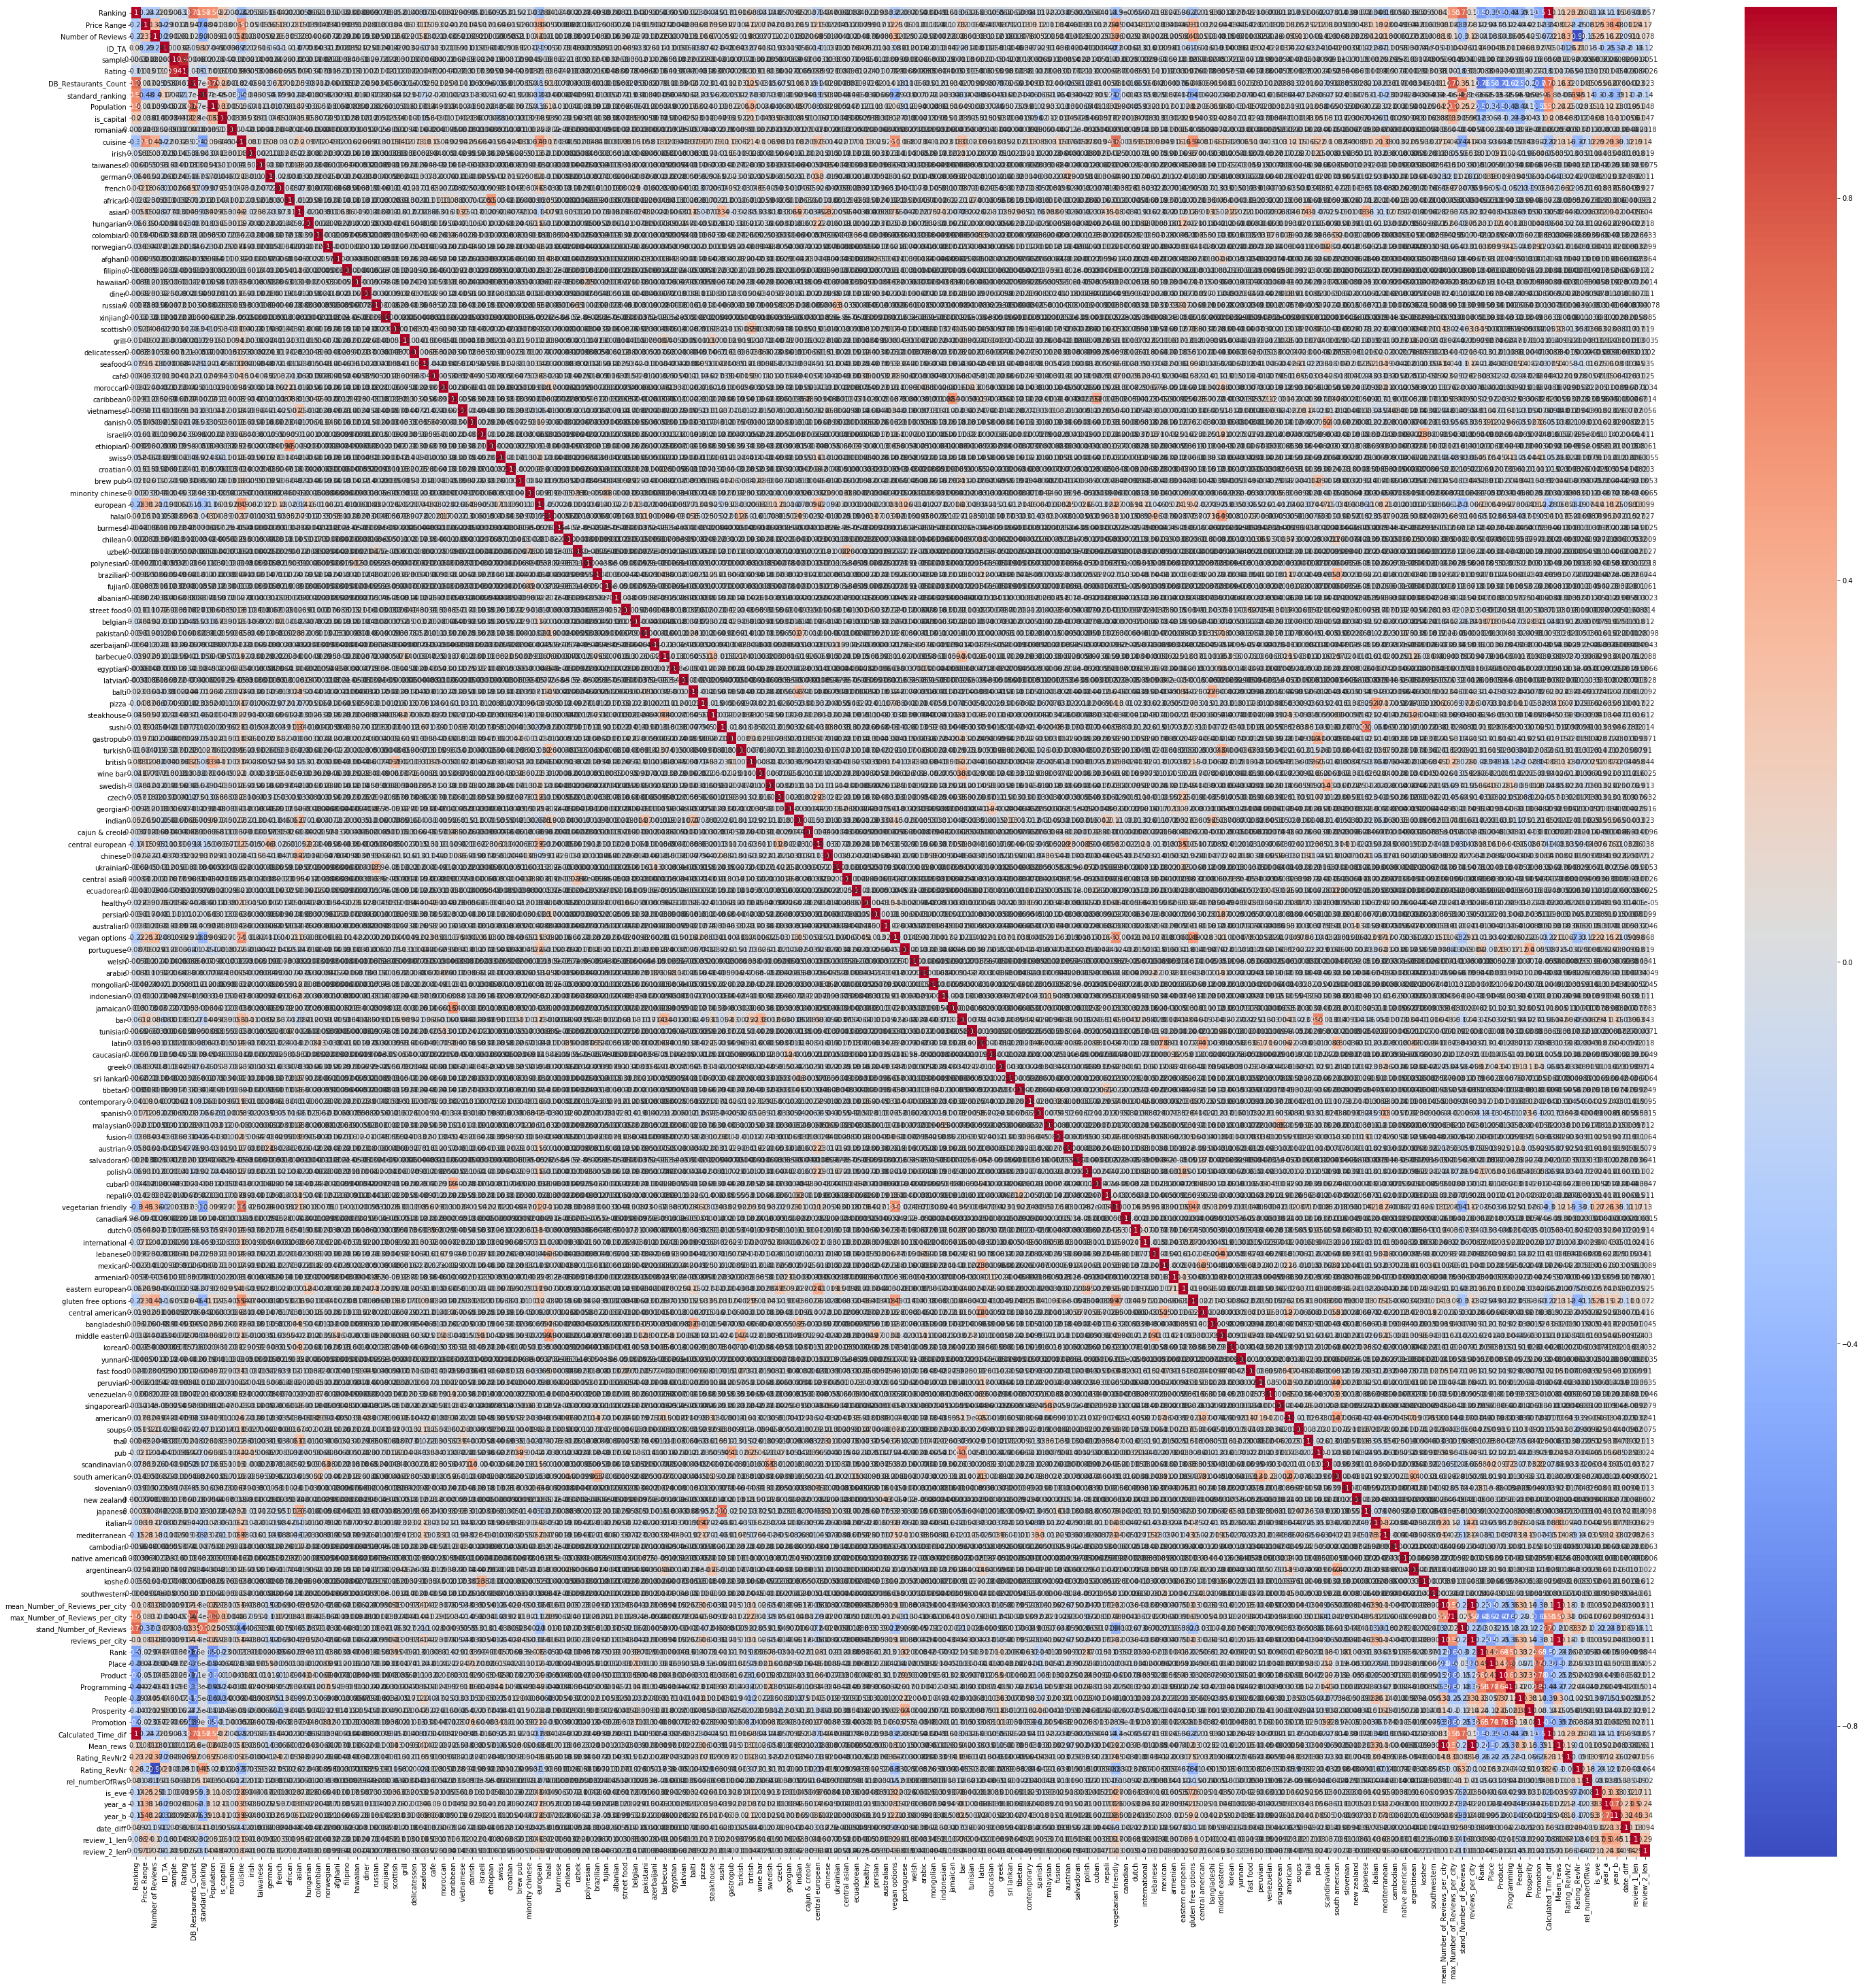

In [77]:
plt.rcParams['figure.figsize'] = (50.0, 50.0)
ax = sns.heatmap(df_preproc.corr(),annot = True, cmap = 'coolwarm')

In [78]:
object_columns = df_preproc.select_dtypes(include='object').columns
df_preproc.drop(object_columns, axis = 1, inplace=True)

In [79]:
df_preproc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 0 to 49999
Columns: 158 entries, Ranking to review_2_len
dtypes: float64(25), int64(133)
memory usage: 60.7 MB


In [80]:
# Теперь выделим тестовую часть
train_data = df_preproc.query('sample == 1').drop(['sample'], axis=1)
test_data = df_preproc.query('sample == 0').drop(['sample'], axis=1)

y = train_data.Rating.values            # наш таргет
X = train_data.drop(['Rating'], axis=1)

**Перед тем как отправлять наши данные на обучение, разделим данные на еще один тест и трейн, для валидации. 
Это поможет нам проверить, как хорошо наша модель работает, до отправки submissiona на kaggle.**

In [81]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [82]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((10000, 157), (40000, 157), (40000, 156), (32000, 156), (8000, 156))

# Model 
Сам ML

In [83]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [84]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [85]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)
y_pred = round_of_rating(y_pred) 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   11.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   26.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [86]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.1659375


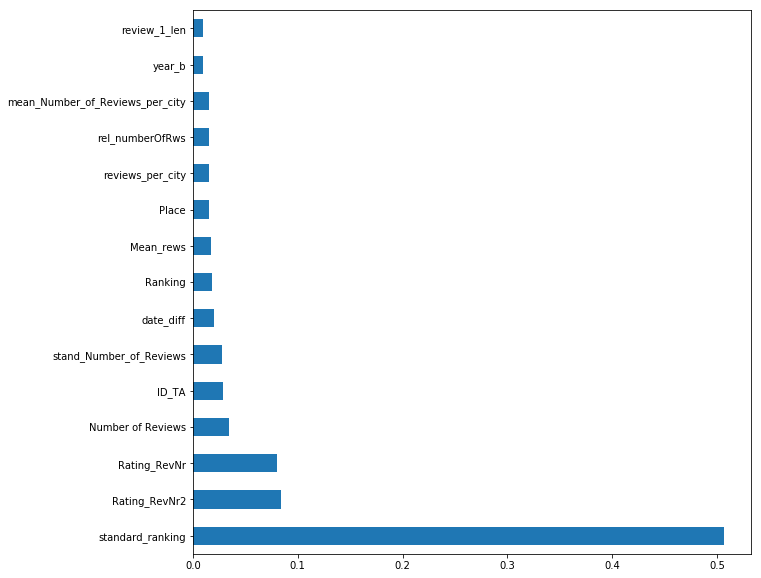

In [87]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

# Submission
Если все устраевает - готовим Submission на кагл

In [88]:
# test_data = test_data.sort_values(by=['Restaurant_id'])
test_data.head(10)

Ranking  Price Range  Number of Reviews     ID_TA  Rating  \
0  12963.0            2           4.000000  10746918     0.0   
1    106.0            2          97.000000   6674944     0.0   
2    810.0            2          28.000000  13129638     0.0   
3   1669.0            3         202.000000    680417     0.0   
4     37.0            3         162.000000   1112354     0.0   
5   5093.0            1          24.000000   8458643     0.0   
6   3704.0            1           2.000000   8758873     0.0   
7   2330.0            0          41.970402   8286886     0.0   
8    771.0            0           2.000000  12947542     0.0   
9    605.0            0          13.000000  12716384     0.0   

   DB_Restaurants_Count  standard_ranking  Population  is_capital  romanian  \
0                  6108              0.43     2190327           1         0   
1                   475             -0.40      643272           1         0   
2                   745             -0.04      488100           1         0   
3                  7193             -0.40     8908081           1         0   
4                   380             -0.48      432864           1         0   
5                  6108             -0.13     2190327           1         0   
6                  1647              0.49      505526           1         0   
7                  1021              0.46     1752286           1         0   
8                   475              0.18      643272           1         0   
9                  1033             -0.26      961609           1         0   

   ...  Mean_rews  Rating_RevNr2  Rating_RevNr  rel_numberOfRws  is_eve  \
0  ...      49.36   51853.000000      2.720000         0.000033       0   
1  ...      26.84   10283.000000    -37.800000        -0.003774       1   
2  ...      97.80   22681.000000     -0.120000        -0.000049       1   
3  ...      57.64  337139.000000    -79.800000        -0.000240       1   
4  ...      21.47    5995.000000    -76.760000        -0.012973       1   
5  ...      49.36  122233.000000     -2.120000        -0.000026       0   
6  ...      53.82    7409.000000      1.980000         0.000132       0   
7  ...      62.02   97792.035941     20.306385         0.000197       0   
8  ...      26.84    1543.000000      1.360000         0.000233       1   
9  ...      30.28    7866.000000     -2.380000        -0.000430       1   

   year_a  year_b  date_diff  review_1_len  review_2_len  
0     0.0     0.0        0.0           0.0           0.0  
1  2017.0  2017.0       37.0          24.0           0.0  
2  2017.0  2017.0       22.0          21.0           9.0  
3  2017.0  2017.0       14.0          14.0          23.0  
4  2018.0  2018.0       15.0          29.0          20.0  
5  2017.0  2017.0        5.0          11.0          18.0  
6     0.0     0.0        0.0           0.0           0.0  
7     0.0     0.0        0.0           0.0           0.0  
8  2018.0  2017.0       88.0          16.0           0.0  
9  2017.0  2017.0       34.0           9.0          10.0  

[10 rows x 157 columns]

In [89]:
test_data = test_data.drop(['Rating'], axis=1)

In [90]:
sample_submission

Restaurant_id  Rating
0             id_0     2.0
1             id_1     2.5
2             id_2     4.0
3             id_3     1.0
4             id_4     4.0
...            ...     ...
9995       id_9995     3.0
9996       id_9996     1.5
9997       id_9997     4.5
9998       id_9998     1.0
9999       id_9999     2.5

[10000 rows x 2 columns]

In [91]:
predict_submission = model.predict(test_data)
predict_submission = np.round(predict_submission*2) / 2

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [92]:
predict_submission

array([3. , 4. , 4.5, ..., 3. , 4.5, 4.5])

In [93]:
sample_submission['Rating'] = predict_submission
sample_submission.to_csv('submission4.csv', index=False)
sample_submission.head(10)

Restaurant_id  Rating
0          id_0     3.0
1          id_1     4.0
2          id_2     4.5
3          id_3     4.5
4          id_4     4.5
5          id_5     4.5
6          id_6     2.0
7          id_7     2.5
8          id_8     4.0
9          id_9     4.5

# What's next?
Или что делать, чтоб улучшить результат:
* Обработать оставшиеся признаки в понятный для машины формат
* Посмотреть, что еще можно извлечь из признаков
* Сгенерировать новые признаки
* Подгрузить дополнительные данные, например: по населению или благосостоянию городов
* Подобрать состав признаков

В общем, процесс творческий и весьма увлекательный! Удачи в соревновании!
